# モデルの作成
QA-LSTMのサンプルプログラムの作成

## 0.データの整形

必要に応じて実行

### 変更前

| 質問                 | 回答                 |
| -------------------- | -------------------- |
| おはよう;おはよ;おは | おはようございます   |
| ありがとう;あり      | ありがとうございます |

### 変更後

| 質問                 | 回答                 |
|-------------------- | -------------------- |
| おはよう | おはようございます   |
| おはよ | おはようございます   |
| おは | おはようございます   |
| ありがとう      | ありがとうございます |
| あり      | ありがとうございます |

In [2]:
import csv
import os

csv_file = open("../script/data/selected_item_list.tsv", "r", encoding="utf_8", errors="", newline="" )

f = csv.reader(csv_file, delimiter="\t", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)

i_temp = []
q_temp = []
a_temp = []
c_temp = []

separate_str = ";"

for row in f:
    for q in row[1].split(separate_str):
        i_temp.append(row[0])
        q_temp.append(q)
        a_temp.append(row[2])
        c_temp.append(row[3])
        
for i in range(4):
    print(i_temp[i] + " : " + q_temp[i] + " : " + a_temp[i] + " : " + c_temp[i])
          
with open('../script/data/item_corpus.tsv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n', delimiter="\t") # 改行コード（\n）を指定しておく
    for i in range(len(q_temp)):
        writer.writerow([q_temp[i],a_temp[i],i_temp[i], c_temp[i]])

悪魔のパスポート : 悪いことをしたい : 悪いことを許す : 悪いことを許してもらえるよ！
悪魔のパスポート : エッチなことしたい : 悪いことを許す : 悪いことを許してもらえるよ！
悪魔のパスポート : 悪いことをしてしまった : 悪いことを許す : 悪いことを許してもらえるよ！
悪魔のパスポート : 許してほしい : 悪いことを許す : 悪いことを許してもらえるよ！


## 1. 質問と応答のセットを読み込む

In [3]:
import csv

csv_file = open("../script/data/item_corpus.tsv", "r", encoding="utf_8", errors="", newline="" )
#リスト形式
f = csv.reader(csv_file, delimiter="\t", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)

q_raw_str = []
a_raw_str = []
i_raw_str = []
c_raw_str = []

for row in f:
    q_raw_str.append(row[0])
    a_raw_str.append(row[1])
    i_raw_str.append(row[2])
    c_raw_str.append(row[3])

# テスト出力
for raw_str in q_raw_str[0:4]:
    print(raw_str)
    
print()
    
for raw_str in a_raw_str[0:4]:
    print(raw_str)

悪いことをしたい
エッチなことしたい
悪いことをしてしまった
許してほしい

悪いことを許す
悪いことを許す
悪いことを許す
悪いことを許す


## 2. 形態素解析

In [4]:
from janome.tokenizer import Tokenizer
t = Tokenizer(mmap=True)

q_analyzed_str = []
a_analyzed_str = []

for raw_str in q_raw_str:
    analyzed_str = t.tokenize(raw_str, wakati=True)
    q_analyzed_str.append(analyzed_str)
    
for raw_str in a_raw_str:
    analyzed_str = t.tokenize(raw_str, wakati=True)
    a_analyzed_str.append(analyzed_str)

# テスト出力
for sentence in q_analyzed_str[0:4]:
    for words in sentence:
        print(words)
    print()

悪い
こと
を
し
たい

エッチ
な
こと
し
たい

悪い
こと
を
し
て
しまっ
た

許し
て
ほしい



## 3. ベクトル化（準備）

※複数回読み込むと重いので、jupyter上では個別に記述している。

In [6]:
from gensim.models import word2vec
w2v_model = word2vec.Word2Vec.load('model/wiki.model')

## 3. ベクトル化（実行）

In [7]:
q_vector = []
a_vector = []

max_i = len(q_analyzed_str)

for i in range(max_i):
    try:
        q_w2v = w2v_model.wv[q_analyzed_str[i]]
        a_w2v = w2v_model.wv[a_analyzed_str[i]]
    except KeyError:
        # print("KeyError:" + str(q_analyzed_str[i]) + " , " + str(a_analyzed_str[i]))
        q_raw_str[i] = "#delete_flag"
        a_raw_str[i] = "#delete_flag"
        continue      
    q_vector.append(w2v_model.wv[q_analyzed_str[i]])
    a_vector.append(w2v_model.wv[a_analyzed_str[i]])
    
# 有効となったデータの数
data_length = len(q_vector)

q_raw_str = [raw_str for raw_str in q_raw_str if raw_str != "#delete_flag"]
a_raw_str = [raw_str for raw_str in a_raw_str if raw_str != "#delete_flag"]

# テスト出力
for vector in q_vector[0:4]:
    print(vector)

[[  0.6229741    2.1709998    2.2289026   -0.60623014  -3.7728913
    0.39637235  -0.73247856   0.16248423   0.8864344    0.2653407
   -3.5211043    1.359272     2.02841      0.7296766   -0.31146595
   -1.1629542    3.9384477    2.985141    -0.49697724   2.3076797
   -0.05107974  -4.0553365    1.3085948    2.2690678    2.193678
   -0.2897625    3.4466994    2.6023798   -6.1449327   -1.8218608
    4.725588    -2.5739422   -2.6209254   -1.5615824   -3.6657228
    3.8053544    0.8398114    3.3175244   -2.111287     1.5911958
   -0.592488    -1.932849     1.3580168    0.43567193  -6.3596306
   -4.6593175    4.4148664   -0.45115024  -4.434269     1.0721774
    0.7633233   -2.0629249    5.4628024   -0.11190756  -3.3118348
    3.2284794    2.495954    -1.5679284    0.47910562   3.1606977
    1.3102827   -0.3779783   -2.9444509    2.138527     0.9133284
    2.901017     2.4522493    4.4584427   -0.97676164  -4.240174
   -0.7353046   -1.6314394    5.0467863    1.396082     0.55110425
    0.6189

## 4. ０埋め化
１つの文で10つの単語ベクトルとする。  
不足分は0で埋め、過多分は切り捨てる。

In [8]:
import numpy as np

# 1文を10個の単語ベクトルに分ける。
max_words_number = 10

q_pad_vector = []
a_pad_vector = []

for vector in q_vector:
    vector_length = 10 if len(vector) > 10 else len(vector)
    pad_vector = np.pad(vector[0:max_words_number], [(0,max_words_number - vector_length),(0,0)], 'constant')
    q_pad_vector.append(pad_vector)
    
for vector in a_vector:
    vector_length = 10 if len(vector) > 10 else len(vector)
    pad_vector = np.pad(vector[0:max_words_number], [(0,max_words_number - vector_length),(0,0)], 'constant')
    a_pad_vector.append(pad_vector)
    
# テスト出力
for pad_vector in q_pad_vector[0:2]:
    print(pad_vector)

[[  0.6229741    2.1709998    2.2289026   -0.60623014  -3.7728913
    0.39637235  -0.73247856   0.16248423   0.8864344    0.2653407
   -3.5211043    1.359272     2.02841      0.7296766   -0.31146595
   -1.1629542    3.9384477    2.985141    -0.49697724   2.3076797
   -0.05107974  -4.0553365    1.3085948    2.2690678    2.193678
   -0.2897625    3.4466994    2.6023798   -6.1449327   -1.8218608
    4.725588    -2.5739422   -2.6209254   -1.5615824   -3.6657228
    3.8053544    0.8398114    3.3175244   -2.111287     1.5911958
   -0.592488    -1.932849     1.3580168    0.43567193  -6.3596306
   -4.6593175    4.4148664   -0.45115024  -4.434269     1.0721774
    0.7633233   -2.0629249    5.4628024   -0.11190756  -3.3118348
    3.2284794    2.495954    -1.5679284    0.47910562   3.1606977
    1.3102827   -0.3779783   -2.9444509    2.138527     0.9133284
    2.901017     2.4522493    4.4584427   -0.97676164  -4.240174
   -0.7353046   -1.6314394    5.0467863    1.396082     0.55110425
    0.6189

## 5. モデルの構築

In [10]:
# 参考
# https://github.com/sachinbiradar9/Question-Answer-Selection

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Bidirectional, Dot, Reshape, Lambda
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
import random

length_of_sequences = 10
in_out_neurons = 100
hidden_neurons = 300

q_inputs = Input(shape=(length_of_sequences, in_out_neurons), name='q_inputs')
q_lstm = Bidirectional(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False), name='q_lstm')(q_inputs)
q_enc = Dense(in_out_neurons, activation='linear', name='q_dense')(q_lstm)

a_inputs = Input(shape=(length_of_sequences, in_out_neurons), name='a_inputs')
a_lstm = Bidirectional(LSTM(hidden_neurons, batch_input_shape=(None, length_of_sequences, in_out_neurons), return_sequences=False), name='a_lstm')(a_inputs)
a_enc = Dense(in_out_neurons, activation='linear', name='a_dense')(a_lstm)

dots = Dot(axes = 1, normalize=True, name='dots')([q_enc, a_enc])
sims = Reshape((1,), name='reshape')(dots)

base_model = Model(inputs=[q_inputs, a_inputs], outputs=sims)
#model.compile(loss=loss_func, optimizer="rmsprop")
#model.compile(loss="hinge", optimizer="rmsprop")

a_good_inputs = Input(shape=(length_of_sequences, in_out_neurons), name='a_good_inputs')
a_bad_inputs = Input(shape=(length_of_sequences, in_out_neurons), name='a_bad_inputs')

good_similarity = base_model([q_inputs, a_good_inputs])
bad_similarity = base_model([q_inputs, a_bad_inputs])

# compute the loss
margin = 0.5
loss = Lambda(lambda x: K.relu(margin - x[0] + x[1]), output_shape=lambda x: x[0])([good_similarity, bad_similarity]) 
#loss = Lambda(lambda x: - x[0] + x[1], output_shape=lambda x: x[0])([good_similarity, bad_similarity]) 

# return training and prediction model
training_model = Model(inputs=[q_inputs, a_good_inputs, a_bad_inputs], outputs=loss, name='training_model')
training_model.compile(loss=lambda y_true, y_pred: y_pred, optimizer="rmsprop")


# 正解データとして、コサイン類似度の最大値1を定義する
#ones = [np.ones(1) for i in range(data_length)]
zeros = [np.zeros(1) for i in range(data_length)]

# listをnp.array形式に変換。
zeros = np.array(zeros)
q_np_array = np.array(q_pad_vector)
a_good_np_array = np.array(a_pad_vector)
# a_bad_np_array = np.array(random.sample(a_pad_vector, len(a_pad_vector)))

# early stopping
# early_stopping = EarlyStopping(monitor='loss', patience=2)

#training_model.fit([q_np_array, a_good_np_array, a_bad_np_array], ones, batch_size=600, epochs=10, callbacks=[early_stopping]) 
max_epoch = 500
for i in range(1, max_epoch+1):
    print("Epoch Set " + str(i) + "/" + str(max_epoch))
    a_bad_np_array = np.array(random.sample(a_pad_vector, len(a_pad_vector)))
    training_model.fit([q_np_array, a_good_np_array, a_bad_np_array], zeros, batch_size=600, epochs=1)
#training_model.fit([q_np_array, a_good_np_array, a_bad_np_array], zeros, batch_size=600, epochs=300) 

# save model
base_model.save("model/item_model.h5")

Epoch Set 1/500
Epoch 1/1
251/251 [==============================] - 8s 31ms/step - loss: 0.4968
Epoch Set 2/500
Epoch 1/1
251/251 [==============================] - 0s 334us/step - loss: 0.3039
Epoch Set 3/500
Epoch 1/1
251/251 [==============================] - 0s 341us/step - loss: 0.2268
Epoch Set 4/500
Epoch 1/1
251/251 [==============================] - 0s 327us/step - loss: 0.1768
Epoch Set 5/500
Epoch 1/1
251/251 [==============================] - 0s 332us/step - loss: 0.1276
Epoch Set 6/500
Epoch 1/1
251/251 [==============================] - 0s 322us/step - loss: 0.1153
Epoch Set 7/500
Epoch 1/1
251/251 [==============================] - 0s 330us/step - loss: 0.0942
Epoch Set 8/500
Epoch 1/1
251/251 [==============================] - 0s 335us/step - loss: 0.0903
Epoch Set 9/500
Epoch 1/1
251/251 [==============================] - 0s 330us/step - loss: 0.0835
Epoch Set 10/500
Epoch 1/1
251/251 [==============================] - 0s 319us/step - loss: 0.0793
Epoch Set 11/500
Epo

Epoch Set 84/500
Epoch 1/1
251/251 [==============================] - 0s 337us/step - loss: 0.0163
Epoch Set 85/500
Epoch 1/1
251/251 [==============================] - 0s 342us/step - loss: 0.0177
Epoch Set 86/500
Epoch 1/1
251/251 [==============================] - 0s 335us/step - loss: 0.0132
Epoch Set 87/500
Epoch 1/1
251/251 [==============================] - 0s 340us/step - loss: 0.0256
Epoch Set 88/500
Epoch 1/1
251/251 [==============================] - 0s 334us/step - loss: 0.0161
Epoch Set 89/500
Epoch 1/1
251/251 [==============================] - 0s 319us/step - loss: 0.0153
Epoch Set 90/500
Epoch 1/1
251/251 [==============================] - 0s 348us/step - loss: 0.0178
Epoch Set 91/500
Epoch 1/1
251/251 [==============================] - 0s 358us/step - loss: 0.0117
Epoch Set 92/500
Epoch 1/1
251/251 [==============================] - 0s 328us/step - loss: 0.0137
Epoch Set 93/500
Epoch 1/1
251/251 [==============================] - 0s 343us/step - loss: 0.0117
Epoch Set 

251/251 [==============================] - 0s 351us/step - loss: 0.0087
Epoch Set 167/500
Epoch 1/1
251/251 [==============================] - 0s 331us/step - loss: 0.0167
Epoch Set 168/500
Epoch 1/1
251/251 [==============================] - 0s 332us/step - loss: 0.0122
Epoch Set 169/500
Epoch 1/1
251/251 [==============================] - 0s 329us/step - loss: 0.0118
Epoch Set 170/500
Epoch 1/1
251/251 [==============================] - 0s 327us/step - loss: 0.0202
Epoch Set 171/500
Epoch 1/1
251/251 [==============================] - 0s 335us/step - loss: 0.0139
Epoch Set 172/500
Epoch 1/1
251/251 [==============================] - 0s 336us/step - loss: 0.0192
Epoch Set 173/500
Epoch 1/1
251/251 [==============================] - 0s 336us/step - loss: 0.0157
Epoch Set 174/500
Epoch 1/1
251/251 [==============================] - 0s 327us/step - loss: 0.0152
Epoch Set 175/500
Epoch 1/1
251/251 [==============================] - 0s 330us/step - loss: 0.0083
Epoch Set 176/500
Epoch 1/1


251/251 [==============================] - 0s 319us/step - loss: 0.0153
Epoch Set 249/500
Epoch 1/1
251/251 [==============================] - 0s 328us/step - loss: 0.0136
Epoch Set 250/500
Epoch 1/1
251/251 [==============================] - 0s 356us/step - loss: 0.0147
Epoch Set 251/500
Epoch 1/1
251/251 [==============================] - 0s 329us/step - loss: 0.0090
Epoch Set 252/500
Epoch 1/1
251/251 [==============================] - 0s 328us/step - loss: 0.0220
Epoch Set 253/500
Epoch 1/1
251/251 [==============================] - 0s 346us/step - loss: 0.0064
Epoch Set 254/500
Epoch 1/1
251/251 [==============================] - 0s 334us/step - loss: 0.0046
Epoch Set 255/500
Epoch 1/1
251/251 [==============================] - 0s 332us/step - loss: 0.0132
Epoch Set 256/500
Epoch 1/1
251/251 [==============================] - 0s 331us/step - loss: 0.0111
Epoch Set 257/500
Epoch 1/1
251/251 [==============================] - 0s 328us/step - loss: 0.0070
Epoch Set 258/500
Epoch 1/1


251/251 [==============================] - 0s 324us/step - loss: 0.0146
Epoch Set 331/500
Epoch 1/1
251/251 [==============================] - 0s 321us/step - loss: 0.0133
Epoch Set 332/500
Epoch 1/1
251/251 [==============================] - 0s 314us/step - loss: 0.0130
Epoch Set 333/500
Epoch 1/1
251/251 [==============================] - 0s 343us/step - loss: 0.0060
Epoch Set 334/500
Epoch 1/1
251/251 [==============================] - 0s 317us/step - loss: 0.0187
Epoch Set 335/500
Epoch 1/1
251/251 [==============================] - 0s 313us/step - loss: 0.0191
Epoch Set 336/500
Epoch 1/1
251/251 [==============================] - 0s 307us/step - loss: 0.0085
Epoch Set 337/500
Epoch 1/1
251/251 [==============================] - 0s 321us/step - loss: 0.0271
Epoch Set 338/500
Epoch 1/1
251/251 [==============================] - 0s 321us/step - loss: 0.0173
Epoch Set 339/500
Epoch 1/1
251/251 [==============================] - 0s 337us/step - loss: 0.0115
Epoch Set 340/500
Epoch 1/1


251/251 [==============================] - 0s 312us/step - loss: 0.0123
Epoch Set 413/500
Epoch 1/1
251/251 [==============================] - 0s 315us/step - loss: 0.0080
Epoch Set 414/500
Epoch 1/1
251/251 [==============================] - 0s 325us/step - loss: 0.0109
Epoch Set 415/500
Epoch 1/1
251/251 [==============================] - 0s 312us/step - loss: 0.0139
Epoch Set 416/500
Epoch 1/1
251/251 [==============================] - 0s 324us/step - loss: 0.0121
Epoch Set 417/500
Epoch 1/1
251/251 [==============================] - 0s 330us/step - loss: 0.0130
Epoch Set 418/500
Epoch 1/1
251/251 [==============================] - 0s 317us/step - loss: 0.0060
Epoch Set 419/500
Epoch 1/1
251/251 [==============================] - 0s 322us/step - loss: 0.0072
Epoch Set 420/500
Epoch 1/1
251/251 [==============================] - 0s 318us/step - loss: 0.0125
Epoch Set 421/500
Epoch 1/1
251/251 [==============================] - 0s 325us/step - loss: 0.0094
Epoch Set 422/500
Epoch 1/1


251/251 [==============================] - 0s 316us/step - loss: 0.0081
Epoch Set 495/500
Epoch 1/1
251/251 [==============================] - 0s 350us/step - loss: 0.0140
Epoch Set 496/500
Epoch 1/1
251/251 [==============================] - 0s 337us/step - loss: 0.0147
Epoch Set 497/500
Epoch 1/1
251/251 [==============================] - 0s 332us/step - loss: 0.0041
Epoch Set 498/500
Epoch 1/1
251/251 [==============================] - 0s 343us/step - loss: 0.0183
Epoch Set 499/500
Epoch 1/1
251/251 [==============================] - 0s 320us/step - loss: 0.0122
Epoch Set 500/500
Epoch 1/1
251/251 [==============================] - 0s 321us/step - loss: 0.0044


## 6. 学習モデルで予測
学習に使用したデータを予測に入れて、コサイン類似度の最高値1に近づいた値になることを確認する。

In [11]:
predicted = base_model .predict([q_np_array[0:10], a_good_np_array[0:10]])
print(predicted)
predicted = base_model .predict([q_np_array[0:10], a_bad_np_array[0:10]])
print(predicted)

[[0.6935376 ]
 [0.7537632 ]
 [0.7662218 ]
 [0.8340464 ]
 [0.8493303 ]
 [0.8325559 ]
 [0.8680396 ]
 [0.846666  ]
 [0.89710146]
 [0.88025075]]
[[-0.11893009]
 [-0.07467178]
 [-0.07787347]
 [-0.20209166]
 [-0.19874695]
 [ 0.05734506]
 [ 0.20308593]
 [-0.04965787]
 [-0.08168881]
 [ 0.13801838]]


## 参考：モデルの図示

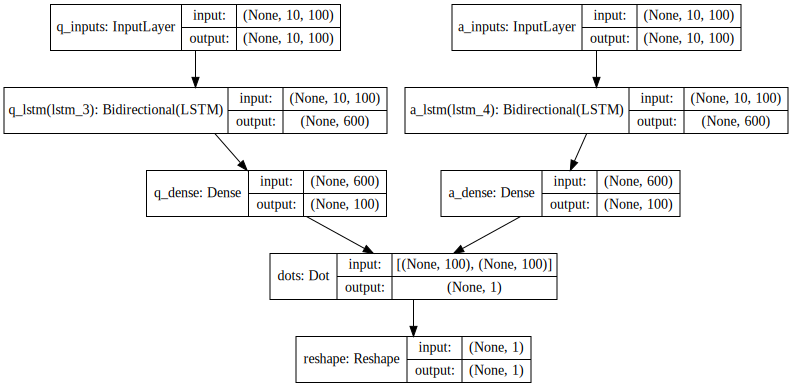

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

#from keras.utils import plot_model
#plot_model(model, to_file='model.png', show_shapes=True)

# モデルを使う

## 概要
学習したモデルは、QとAで予測する仕組みとなっている。  
予め、Aを入れた時のベクトルの値は計算しておく。  
Qが与えられた時、どのAが最も近いかどうかを総当たりで見ていく。

## 0.モデルをロードする

学習済みのモデルが既に存在する場合は、以下を実行する。

In [13]:
from keras.models import load_model
import numpy as np

# load model
base_model = load_model('model/item_model.h5')

# numpy形式に変換
q_np_array = np.array(q_pad_vector)
a_good_np_array = np.array(a_pad_vector)

/home/me/dev/doraemon-tools/notebooks/vendor/bundle/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## 1. 中間層の出力を得る

qとaの中間層の出力（100次元）を得る。  
値が正しいことを確認するため、コサイン類似度を計算している。  

In [18]:
from keras.models import Model
import numpy as np

# get_input_at(0 or 1 or2)は、入力が3つあるレイヤーなので使用する。


# model.input
intermediante_layer_model = Model(inputs=base_model .get_input_at(0), outputs=base_model .get_layer("q_dense").output)
q_predict = intermediante_layer_model.predict([q_np_array, a_good_np_array])

intermediante_layer_model = Model(inputs=base_model .get_input_at(0), outputs=base_model .get_layer("a_dense").output)
a_predict = intermediante_layer_model.predict([q_np_array, a_good_np_array])

def cos_sim(v1, v2):
    return (np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

print(cos_sim(q_predict[0], a_predict[0]))

0.7495739


## 2. 入力のベクトル化

学習時と同様、入力に対して

1. 形態素解析
2. ベクトル化
3. 0穴埋め

以上を実施する。

In [19]:
from janome.tokenizer import Tokenizer
import numpy as np
t = Tokenizer(mmap=True)

# 1. 形態素解析
input_str = "肌が汚い"
analyzed_str = t.tokenize(input_str, wakati=True)

# 2. ベクトル化
input_vector = w2v_model.wv[analyzed_str]

# 3. 0穴埋め

# max_words_number = 10 と事前に定義済み
vector_length = 10 if len(vector) > 10 else len(vector)
input_pad_vector = np.pad(input_vector[0:max_words_number], [(0,max_words_number - vector_length),(0,0)], 'constant')

## 3. 入力のベクトルを学習済みのモデルに通す

In [20]:
from keras.models import Model
import numpy as np

intermediante_layer_model = Model(inputs=base_model .get_layer("q_inputs").input, outputs=base_model .get_layer("q_dense").output)
input_pad_vector.resize(1,10,100) # 学習時は複数のセットで学習したが、今回は1つのセットなので、resizeをして入力モデルの形式に合わせている。

input_predict = intermediante_layer_model.predict(input_pad_vector)

input_predict = input_predict[0] # 複数セットから１つのセットに戻す
print(input_predict)

[ 0.12831989 -0.77283764  0.14263217  0.33572116 -0.01106704  0.03034907
 -0.12322141 -0.330418   -0.252441   -0.03235274  0.03953935 -0.4931499
 -0.16416417  0.1689884  -0.02027028 -0.13300785 -0.21965244  0.5916106
 -0.331489    0.03382039 -0.14216885  0.23661683  0.01345351 -0.09898265
 -0.17544967  0.22400631  0.22230016 -0.14068705  0.23139982 -0.36278608
  0.15361144  0.34109983  0.18548769  0.02610799  0.09542496  0.03760283
 -0.10667285 -0.301847    0.26110566  0.22182232 -0.19801614 -0.04151621
 -0.02552597 -0.23621082  0.002811    0.3277771  -0.16884273  0.19163035
 -0.37642235 -0.22711763  0.14172393 -0.6102615  -0.01490653 -0.05003352
 -0.33021113 -0.15144594 -0.41870725 -0.05862306  0.00459615  0.08215988
  0.09403215  0.00678706  0.10959319  0.19023657  0.1131466   0.01733432
 -0.05343209  0.14085336  0.26520923  0.14305192 -0.16522239  0.18326718
  0.15215808 -0.12057348 -0.36308095 -0.22179376 -0.18250383  0.02808467
  0.31567436 -0.14994757 -0.25241998  0.1088291  -0.1

## 4. 通したベクトルと最も近い回答のベクトルを探す

In [21]:
import numpy as np

def cos_sim(v1, v2):
    return (np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

cos_sim_results = []

for predict in a_predict:
    cos_sim_results.append(cos_sim(input_predict, predict))

cos_sim_results = np.array(cos_sim_results)

print("input_predict")
print(input_predict)
#print(a_predict[0])
#print(cos_sim(input_predict, predict))

print("cos_sim_results.argmax() : " + str(cos_sim_results.argmax()))
print("cos_sim_results.max() : " + str(cos_sim_results.max()))

#for i, result in enumerate(cos_sim_results):
#    print(q_raw_str[i] + " / " + a_raw_str[i] + " / " + str(result))

input_predict
[ 0.12831989 -0.77283764  0.14263217  0.33572116 -0.01106704  0.03034907
 -0.12322141 -0.330418   -0.252441   -0.03235274  0.03953935 -0.4931499
 -0.16416417  0.1689884  -0.02027028 -0.13300785 -0.21965244  0.5916106
 -0.331489    0.03382039 -0.14216885  0.23661683  0.01345351 -0.09898265
 -0.17544967  0.22400631  0.22230016 -0.14068705  0.23139982 -0.36278608
  0.15361144  0.34109983  0.18548769  0.02610799  0.09542496  0.03760283
 -0.10667285 -0.301847    0.26110566  0.22182232 -0.19801614 -0.04151621
 -0.02552597 -0.23621082  0.002811    0.3277771  -0.16884273  0.19163035
 -0.37642235 -0.22711763  0.14172393 -0.6102615  -0.01490653 -0.05003352
 -0.33021113 -0.15144594 -0.41870725 -0.05862306  0.00459615  0.08215988
  0.09403215  0.00678706  0.10959319  0.19023657  0.1131466   0.01733432
 -0.05343209  0.14085336  0.26520923  0.14305192 -0.16522239  0.18326718
  0.15215808 -0.12057348 -0.36308095 -0.22179376 -0.18250383  0.02808467
  0.31567436 -0.14994757 -0.25241998  0

## 5. ベクトル配列の添字から元の回答を探して返す

In [22]:
print(input_str) # 入力文
print(q_raw_str[cos_sim_results.argmax()])  # 参考出力：学習時の質問
print(a_raw_str[cos_sim_results.argmax()])  # 返答
print(i_raw_str[cos_sim_results.argmax()])  # 返答
print(c_raw_str[cos_sim_results.argmax()])  # 返答

肌が汚い
イケメンになりたい
好きな顔になる
取り消し消しゴムと目鼻ペン
好きな顔に変えよう！
